# Разработка стратегии взаимодействия с пользователями на основе аналитических данных для сети фитнес-центров «Культурист-датасаентист».

# Описание проекта

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. Как понять, что клиент больше не с вами? Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо.

Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас.

Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Ваша задача — провести анализ и подготовить план действий по удержанию клиентов.

**А именно:**

- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;

- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;

- проанализировать основные признаки, наиболее сильно влияющие на отток;

- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

    1) выделить целевые группы клиентов;
    
    2) предложить меры по снижению оттока;
    
    3) определить другие особенности взаимодействия с клиентами.

## Шаг 1. Загрузите данные

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

import itertools
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_csv('/datasets/gym_churn.csv')
df.sample()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
153,1,1,0,0,1,1,0,31,329.546123,1.0,1,2.657214,2.707547,0


У нас есть подготовленные данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. 

Таблица включает в себя:

- `gender` — пол
- `Near_Location` — проживание или работа в районе, где находится фитнес-центр
- `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
- `Phone` — наличие контактного телефона
- `Age` — возраст
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах) Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента
- `Contract_period` — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах)
- `Group_visits` — факт посещения групповых занятий
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон
- `Churn` — факт оттока в текущем месяце

## Шаг 2. Проведите исследовательский анализ данных (EDA)

### Посмотрите на датасет: есть ли в нем отсутствующие признаки, изучите средние значения и стандартные отклонения

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


В таблице:
    

    - 4000 строк
    - 14 колонок
    - изменять данные нет необходимости

In [4]:
print('Дубликатов в таблице - {}'.format(df.duplicated().sum()))

Дубликатов в таблице - 0


In [5]:
df['gender'].value_counts()

1    2041
0    1959
Name: gender, dtype: int64

- `gender` - пол


    - В данных нет информации, каким полом являются значения "0" и "1".
    - Для дальнейшего анализа определим, что "0" - мужской пол, а "1" - женский пол.
    - Таким образом, получается что 51,02% клиентов сети фитнес-центров являются женщины и 48,98% - мужчины

In [6]:
df['Near_Location'].value_counts()

1    3381
0     619
Name: Near_Location, dtype: int64

- `Near_Location` - проживание или работа в районе, где находится фитнес-центр


    - 3381 клиент проживает или работает в том районе, где находится фитнес-центр, что составляет 84,53%
    от общего количества клиентов.    
    - И 15,47% клиентов ( 619 человек) не работают и не живут в районе, где располагается фитнес-центр

In [7]:
df['Partner'].value_counts()

0    2053
1    1947
Name: Partner, dtype: int64

- `Partner` - сотрудник компании-партнёра клуба


    - 2053 клиентов не являются сотрудниками компании-партнёра клуба (чьи сотрудники могут получать скидки на абонемент).
    - Что составляет 51,33%   
    - 1947 клиентов являются сотрудниками компании-партнёра клуба, что составляет 48,67% 

In [8]:
df['Promo_friends'].value_counts()

0    2766
1    1234
Name: Promo_friends, dtype: int64

- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)


    - 2766 клиентов не использовал промо-код от знакомого при оплате первого абонемента. Что составляет 69,15%    
    - 1234 клиентов использовали промо-код в рамках акции «приведи друга», что составляет 30,85% 

In [9]:
df['Phone'].value_counts()

1    3614
0     386
Name: Phone, dtype: int64

- `Phone` — наличие контактного телефона


    - 3614 клиента оставили контактный телефон (90,5%).
    - 386 клиентов при покупке не указали контактный телефон (9,65%)

In [10]:
df['Contract_period'].value_counts()

1     2207
12     960
6      833
Name: Contract_period, dtype: int64

- `Contract_period` — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)


    - Большинство клиентов приобретают абонемент на 1 месяц - 2207 человек (55,18%)    
    - 960 человек (24%) приобрели абонементы на год.    
    - 833 человека (20,82%) приобрели абонемент на 6 месяцев    
    - никто из клиентов не приобрел абонемент на 3 месаца, хотя в описании к данным указано, что такая опция есть.

In [11]:
df['Group_visits'].value_counts()

0    2351
1    1649
Name: Group_visits, dtype: int64

- `Group_visits` — факт посещения групповых занятий
 
 
    - 58,78% клиентов не посещают групповые занятия, а занимаются самостоятельно или с личным тренером
    - 41,22% клиентов посещают групповые занятия

In [12]:
df['Age'].value_counts()

29    468
30    457
28    447
31    434
27    378
32    364
26    300
33    253
25    231
34    174
24    148
35     98
23     82
36     48
22     33
37     29
21     24
20     14
38     10
39      3
19      2
18      2
41      1
Name: Age, dtype: int64

In [13]:
df['Age'].describe()

count    4000.000000
mean       29.184250
std         3.258367
min        18.000000
25%        27.000000
50%        29.000000
75%        31.000000
max        41.000000
Name: Age, dtype: float64

- `Age` — возраст


    - Основная возрастная категория клиентов с 27 лет до 32 лет. ( 2548 человек или 63,7%)    
    - Фитнес-центры практически не посещают молодые люди с 18 до 23 лет. Их количество составило 157 человек или 3,9%    
    - Так же фитнес-центры не пользуются популярностью у клиентов старше 35 лет. 
    - Возрастная категория 36-41 год - 91 человек или 2,3% от общего числа    
    - 75% всех клиентов не старше - 31 года.    
    - средний возраст всех посетителей - 29 лет

In [14]:
df['Avg_additional_charges_total'].describe()

count    4000.000000
mean      146.943728
std        96.355602
min         0.148205
25%        68.868830
50%       136.220159
75%       210.949625
max       552.590740
Name: Avg_additional_charges_total, dtype: float64

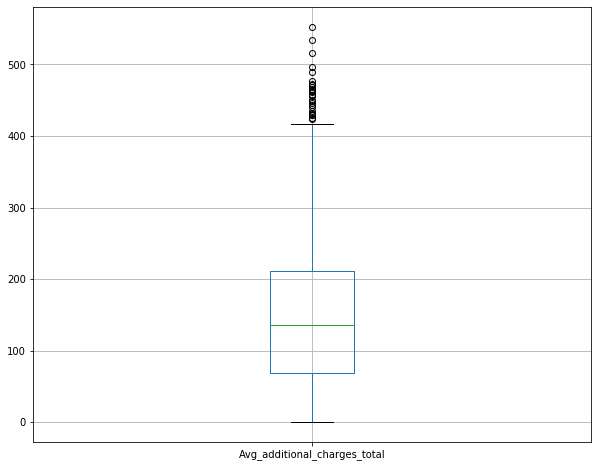

In [15]:
df.boxplot(column='Avg_additional_charges_total', figsize=(10, 8))

- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон


    - минимальный чек на доп.услуги - 0.15 у.е.
    - 25% чеков на доп.услуги не превышают сумму - 68.87 у.е.
    - среднее значение чека на доп.услуги - 146.94 у.е
    - медиана - 136.22 у.е. Медиана меньше среднего значения, значит данные скошены в правую сторону
    - 75% чеков на доп.услуги не превышают сумму - 210.95 у.е.
    - 90% чеков на доп.услуги не превышают сумму  - 410 у.е.
    - Выбросы начинаются от 410 у.е. до 552,59 у.е. Самый большой выброс - чек на сумму  552.59 у.е. 

In [16]:
df[df['Avg_class_frequency_current_month'] == 0]['Avg_class_frequency_current_month'].count()

181

- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц


    - минимальное количество посещений в неделю - 0 раз. 181 человек еще не посетили фитнес-центр, это 2,2%
    - 25% человек в среднем посетили клуб 0.96 раз в неделю за прошлый месяц
    - среднее значение посещений в недею за прошлый месяц - 1.77 раз
    - медиана - 1.72 раз. Медиана меньше среднего значения, значит данные скошены в правую сторону
    - 75% человек в среднем посещают клуб 2.51 раз в неделю
    - 90% человек в прошлом месяце в среднем посетили клуб не более 4.9 раз в неделю
    - Выбросы начинаются от 4,9 до 6.15 раз в неделю. Самый большой выброс - 6,15 раз в неделю.

In [17]:
df['Lifetime'].describe()

count    4000.000000
mean        3.724750
std         3.749267
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max        31.000000
Name: Lifetime, dtype: float64

In [18]:
df[df['Lifetime'] == 0]['Lifetime'].count()

487

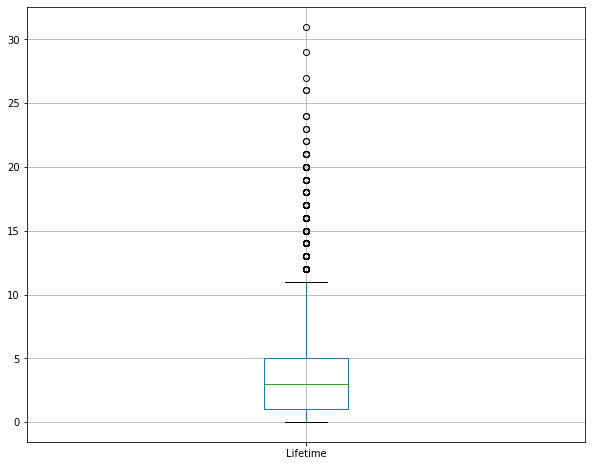

In [19]:
df.boxplot(column='Lifetime', figsize=(10, 8))

- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах)


    - у 487 клиентов еще не прошло месяца с момента первого обращения, что составляет 12,18% от общего количества
    - У 25% человек прошел 1 месяц с момента первого обращения
    - среднее значение - 3.7 месяца с момента первого обращения
    медиана - 3 месяца. Медиана меньше среднего значения, значит данные скошены в правую сторону
    - У 75% человек прошло 5 месяц с момента первого обращения
    - У 90% человек прошло 11 месяц с момента первого обращения
    Выбросы начинаются от 12 до 31 месяца. Самый большой выброс - 31 месяц

In [20]:
df['Churn'].value_counts()

0    2939
1    1061
Name: Churn, dtype: int64

- `Churn` — факт оттока в текущем месяце


    - 1061 прекратили посещать фитнес-центр, что составляет 26,53%
    - 2939 клиентов продолжают посещать фитнес-центры, что составляет 73,47% от общего количества

### Посмотрите на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался (воспользуйтесь методом groupby())

In [21]:
df.groupby(['Churn', 'gender']).agg({'gender':'count'})

gender
Churn gender        
0     0         1440
      1         1499
1     0          519
      1          542

Text(0.5, 0, 'Остались                  Ушли')

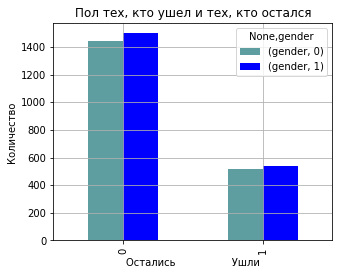

In [22]:
df.pivot_table(index='Churn', columns='gender', aggfunc=({'gender':'count'}))\
    .plot(kind='bar', grid=True, color = ('cadetblue', 'b'),  figsize=(5, 4))
plt.title('Пол тех, кто ушел и тех, кто остался')
plt.ylabel('Количество')
plt.xlabel('Остались                  Ушли')

**gender**


_Группа, продолжающих посещение:_


    - 49% мужчин
    - 51% женщин

_группа клиентов, которые прекратили посещение:_


    - 48,92% мужчин
    - 51,08% женщин
    
    
Можем сделать предположение, что пол не является важным фактором при определении вероятности оттока

In [23]:
df.groupby(['Churn', 'Near_Location']).agg({'Near_Location':'count'})

Near_Location
Churn Near_Location               
0     0                        373
      1                       2566
1     0                        246
      1                        815

Text(0.5, 0, 'Остались                  Ушли')

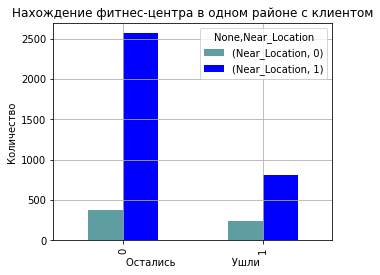

In [24]:
df.pivot_table(index='Churn', columns='Near_Location', aggfunc=({'Near_Location':'count'}))\
    .plot(kind='bar', grid=True, color = ('cadetblue', 'b'),  figsize=(5, 4))
plt.title('Нахождение фитнес-центра в одном районе с клиентом')
plt.ylabel('Количество')
plt.xlabel('Остались                  Ушли')

**Near_Location**


_Группа, продолжающих посещение:_

    
    - 87,3% живут или работают в одном районе с клубом
    - 12,69% клиентов живут или работают в другом районе.

_Противоположная ситуация в группе клиентов, которые прекратили посещение:_

    
    - 76,81% проживали/работали с другом районе
    - 23,19% проживали/работлаи в одном районе с клубом


Можем сделать предположение, что фактор удаленности клуба от места проживания или работы является важным

In [25]:
df.groupby(['Churn', 'Partner']).agg({'Partner':'count'})

Partner
Churn Partner         
0     0           1369
      1           1570
1     0            684
      1            377

Text(0.5, 0, 'Остались                  Ушли')

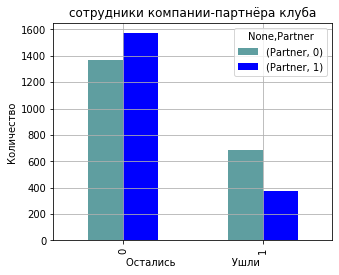

In [26]:
df.pivot_table(index='Churn', columns='Partner', aggfunc=({'Partner':'count'}))\
    .plot(kind='bar', grid=True, color = ('cadetblue', 'b'), figsize=(5, 4))
plt.title('сотрудники компании-партнёра клуба')
plt.ylabel('Количество')
plt.xlabel('Остались                  Ушли')

**Partner**


_Группа, продолжающих посещение:_


    - 53,42% являются сотрудник компании-партнёра клуба, получили скидку на абонемент
    - 46,58% не являются сотрудник компании-партнёра клуба

_группе клиентов, которые прекратили посещение:_


    - 35,53% являются сотрудник компании-партнёра клуба, получили скидку на абонемент
    - 64,47% не являются сотрудник компании-партнёра клуба


Можем сделать предположение, что наличие скидки на абонемент у сотрудников компании-партнёра клуба имеет значение при прогнозировании возможного оттока клиентов

In [27]:
df.groupby(['Churn', 'Promo_friends']).agg({'Promo_friends':'count'})

Promo_friends
Churn Promo_friends               
0     0                       1900
      1                       1039
1     0                        866
      1                        195

Text(0.5, 0, 'Остались                  Ушли')

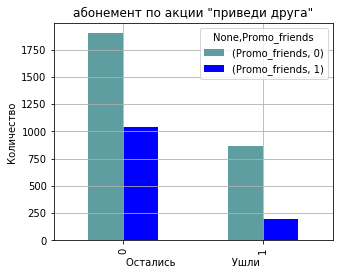

In [28]:
df.pivot_table(index='Churn', columns='Promo_friends', aggfunc=({'Promo_friends':'count'}))\
    .plot(kind='bar', grid=True, color = ('cadetblue', 'b'), figsize=(5, 4))
plt.title('абонемент по акции "приведи друга"')
plt.ylabel('Количество')
plt.xlabel('Остались                  Ушли')

**Promo_friends**


_Группа, продолжающих посещение:__


    - 64,65% клиентов не получили скидку на первый абонемент по акции "приведи друга"
    - 35,35% клиентов получили скидку на первый абонемент по акции "приведи друга"


_группе клиентов, которые прекратили посещение:_

    - 81,62% клиентов не получили скидку на первый абонемент по акции "приведи друга"
    - 18,38% клиентов получили скидку на первый абонемент по акции "приведи друга"
    
    
Можем сделать предположение, что наличие скидки на первый абонемент по акции "приведи друга" имеет значение при прогнозировании возможного оттока клиентов

In [29]:
df.groupby(['Churn', 'Phone']).agg({'Phone':'count'})

Phone
Churn Phone       
0     0        283
      1       2656
1     0        103
      1        958

Text(0.5, 0, 'Остались                  Ушли')

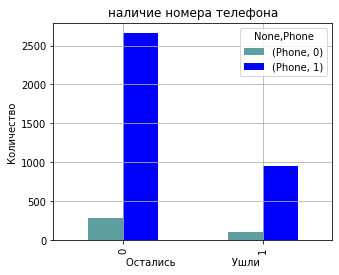

In [30]:
df.pivot_table(index='Churn', columns='Phone', aggfunc=({'Phone':'count'}))\
    .plot(kind='bar', grid=True, color = ('cadetblue', 'b'), figsize=(5, 4))
plt.title('наличие номера телефона')
plt.ylabel('Количество')
plt.xlabel('Остались                  Ушли')

**Phone**


_Группа, продолжающих посещение:_


    - 90,37% клиентов указали телефон
    - у 9,3% клиентов отсутствует номер телефона


_группе клиентов, которые прекратили посещение:_


    - 90,29 % клиентов указали телефон
    - у 9,71 % клиентов отсутствует номер телефона


Можем сделать предположение, что наличие отсутствие/наличие номера телефона клиента не является важным фактором при определении вероятности оттока

In [31]:
df.groupby(['Churn', 'Group_visits']).agg({'Group_visits':'count'})

Group_visits
Churn Group_visits              
0     0                     1575
      1                     1364
1     0                      776
      1                      285

Text(0.5, 0, 'Остались                  Ушли')

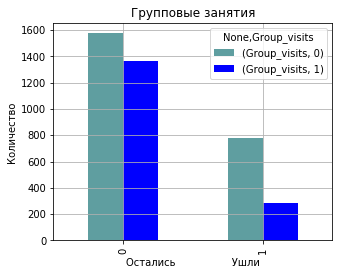

In [32]:
df.pivot_table(index='Churn', columns='Group_visits', aggfunc=({'Group_visits':'count'}))\
    .plot(kind='bar', grid=True, color = ('cadetblue', 'b'), figsize=(5, 4))
plt.title('Групповые занятия')
plt.ylabel('Количество')
plt.xlabel('Остались                  Ушли')

**Group_visits**


_Группа, продолжающих посещение:_

    
    - 53,59% клиентов не посещают групповые занятия
    - 46,41 % клиентов ходят на групповые занятия


_группе клиентов, которые прекратили посещение:_

    
    - 73,14 % клиентов не посещали групповые занятия
    - 26,86 % клиентов ходили на групповые занятия


Можем сделать предположение, что посещение групповых занятий имеет значение при прогнозировании возможного оттока клиентов

In [33]:
df.groupby(['Churn']).agg({'Age':'mean', 'Lifetime':'mean', 'Contract_period':'mean',\
                           'Month_to_end_contract':'mean', 'Avg_class_frequency_total':'mean',\
                           'Avg_class_frequency_current_month':'mean', 'Avg_additional_charges_total':'mean'})

,Age,Lifetime,Contract_period,Month_to_end_contract,Avg_class_frequency_total,Avg_class_frequency_current_month,Avg_additional_charges_total
Churn,,,,,,,
0,29.976523,4.711807,5.747193,5.283089,2.024876,2.027882,158.445715
1,26.989632,0.990575,1.728558,1.662582,1.474995,1.044546,115.082899


**возраст**

    средний возраст в группе продолжающих посещение - 29.98
    средний возраст в группе прекративших посещение - 26.99

        Вывод: уходят в основном "молодая категория" клиентов


**время с момента первого обращения в фитнес-центр (в месяцах)**


    средний Lifetime в группе продолжающих посещение - 4.7
    средний Lifetime в группе прекративших посещение - 0.99
    
        Вывод: уходят в основном новые клиенты


**длительность текущего действующего абонемента**


    средняя длительность абонемента в группе продолжающих посещение - 5.75
    средняя длительность абонемента в группе прекративших посещение - 1.73
        
        Вывод: уходят в основном клиенты, купившие абонемент на короткий срок

**срок до окончания текущего действующего абонемента (в месяцах)**


    средний срок до окончания абонемента в группе продолжающих посещение - 5.28
    средний срок до окончания абонемента в группе прекративших посещение - 1.66
        
        Вывод: уходят клиенты, у которых скоро заказнчивается абонемент


**средняя частота посещений в неделю за все время с начала действия абонемента**


    среднее значение в группе продолжающих посещение - 2.02
    среднее значение в группе прекративших посещение - 1,47
        
        Вывод: клиенты, прекратившие посещение, реже посещали клуб


**средняя частота посещений в неделю за предыдущий месяц**


    среднее значение в группе продолжающих посещение - 2.03
    среднее значение в группе прекративших посещение - 1.04
    
        Вывод: клиенты, прекратившие посещение, реже посещали клуб в последний месяц


**суммарная выручка от других услуг фитнес-центра**


    среднее значение в группе продолжающих посещение - 158.45 у.е.
    среднее значение в группе прекративших посещение - 115.08 у.е.
    
        Вывод: клиенты, прекратившие посещение, меньше тратили на доп.услуги

Text(0.5, 0, 'Возраст')

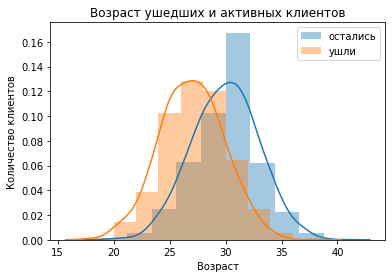

In [34]:
sns.distplot(df[df['Churn']==0]['Age'], bins=10, label='остались')
sns.distplot(df[df['Churn']==1]['Age'], bins=10, label='ушли')
plt.legend()
plt.title('Возраст ушедших и активных клиентов')
plt.ylabel('Количество клиентов')
plt.xlabel('Возраст')

- Видим, что график распределения возраста, клиенто ушедших в отток, смещен в лево относительно графика клиентов,
продолжающих посещать клуб. 
- Большинству клиентов, ушедших в отток - 27-29 лет.
- Большинство клиентов, продолжающих посещение - 30-33 года

Text(0.5, 0, 'Количество месяцев Lifetime')

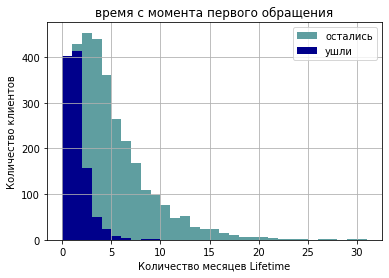

In [35]:
ax = df[df['Churn']==0]['Lifetime'].hist(bins=31, color = 'cadetblue', range=(0,31), label = 'остались')
df[df['Churn']==1]['Lifetime'].hist(ax=ax, bins=31, color = 'darkblue', range=(0,31), label = 'ушли')
plt.legend()
plt.title('время с момента первого обращения')
plt.ylabel('Количество клиентов')
plt.xlabel('Количество месяцев Lifetime')

**Lifetime**


_группа, ушедшая в отток:_

    
    прошло 1-2 месяца с момента первого обращения в фитнес-центр
    
_группа, продолжающая посещение:_

    
    прошло более 6 месяцев с момента первого обращения в фитнес-центр

Text(0.5, 0, 'Количество месяцев в абонементе')

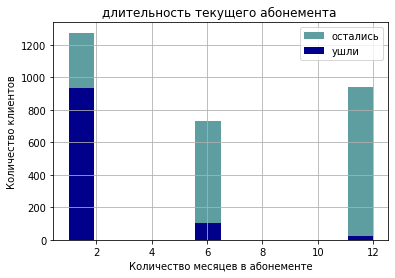

In [36]:
ax = df[df['Churn']==0]['Contract_period'].hist(bins=12, color = 'cadetblue', range=(1,12), label = 'остались')
df[df['Churn']==1]['Contract_period'].hist(ax=ax, bins=12, color = 'darkblue', range=(1,12), label = 'ушли')
plt.legend()
plt.title('длительность текущего абонемента ')
plt.ylabel('Количество клиентов')
plt.xlabel('Количество месяцев в абонементе')

**Contract_period**


_группа, ушедшая в отток:_


    в основном приобретают абонементы сроком на 1 месяц
    
    
_группа, продолжающая посещение:_


    так же приобретают абонементы срокром на 6 и на 12 месяцев

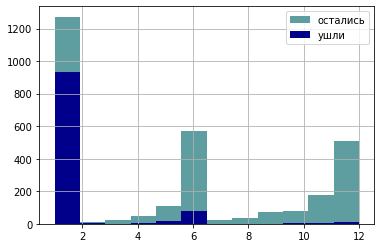

In [37]:
ax = df[df['Churn']==0]['Month_to_end_contract'].hist(bins=12, color = 'cadetblue', range=(1,12), label = 'остались')
df[df['Churn']==1]['Month_to_end_contract'].hist(ax=ax, bins=12, color = 'darkblue', range=(1,12), label = 'ушли')
plt.legend()

**Month_to_end_contract**


_группа, ушедшая в отток:_
    

    абонемент закончится через месяц
    
    
_группа, продолжающая посещение:_
    

    абонементы так же заканчиваются через 5-6 и 10-12 месяцев

Text(0.5, 0, 'средняя частота посещений в неделю')

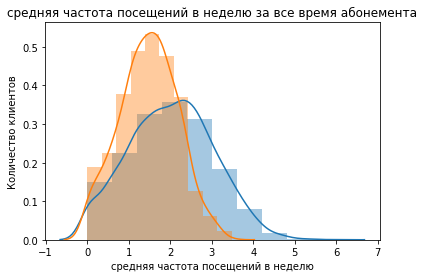

In [38]:
sns.distplot(df[df['Churn']==0]['Avg_class_frequency_total'], bins=10, label='0')
sns.distplot(df[df['Churn']==1]['Avg_class_frequency_total'], bins=10, label='1')
plt.title('средняя частота посещений в неделю за все время абонемента')
plt.ylabel('Количество клиентов')
plt.xlabel('средняя частота посещений в неделю')

**Avg_class_frequency_total**


_группа, ушедшая в отток:_

    
    график смещен в левую сторону, относительно группы, продолжающей посещение. Большинство клиентов ходили 1-2 раза в неделю, и не чаще 3-4 раз


_группа, продолжающая посещение:_

    
    Клиенты в основном посещают клуб 2-3 раза. Часть клиентов посещает клуб 3-4 раза в неделю

Text(0.5, 0, 'средняя частота посещений')

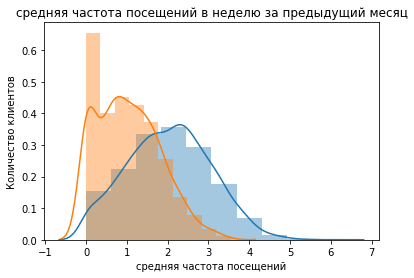

In [39]:
sns.distplot(df[df['Churn']==0]['Avg_class_frequency_current_month'], bins=10, label='0')
sns.distplot(df[df['Churn']==1]['Avg_class_frequency_current_month'], bins=10, label='1')
plt.title('средняя частота посещений в неделю за предыдущий месяц')
plt.ylabel('Количество клиентов')
plt.xlabel('средняя частота посещений')

**Avg_class_frequency_current_month**


_группа, ушедшая в отток:_

    
    за предыдущий месяц, большинство клиентов либо не посещали клуб, либо посещали 1 раз в неделю.


_группа, продолжающая посещение:_

    
    за предыдущий месяц большинство клиентов посетили клуб 2-3 раза

Text(0.5, 0, 'выручка')

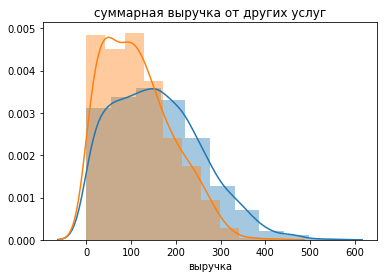

In [40]:
sns.distplot(df[df['Churn']==0]['Avg_additional_charges_total'], bins=10, label='0')
sns.distplot(df[df['Churn']==1]['Avg_additional_charges_total'], bins=10, label='1')
plt.title('суммарная выручка от других услуг')
plt.xlabel('выручка')

**Avg_additional_charges_total**


_группа, ушедшая в отток:_

    
    суммарная вырочка за доп.услуги от 0 до 150 у.е. График расположен левее относительно клиентов, продолжающих посещение


_группа, продолжающая посещение:_

    
    суммарная вырочка за доп.услуги от 0 до 210 у.е.

### Матрица корреляций

In [41]:
#корреляционная матрица
corr_m = df.corr().round(2)

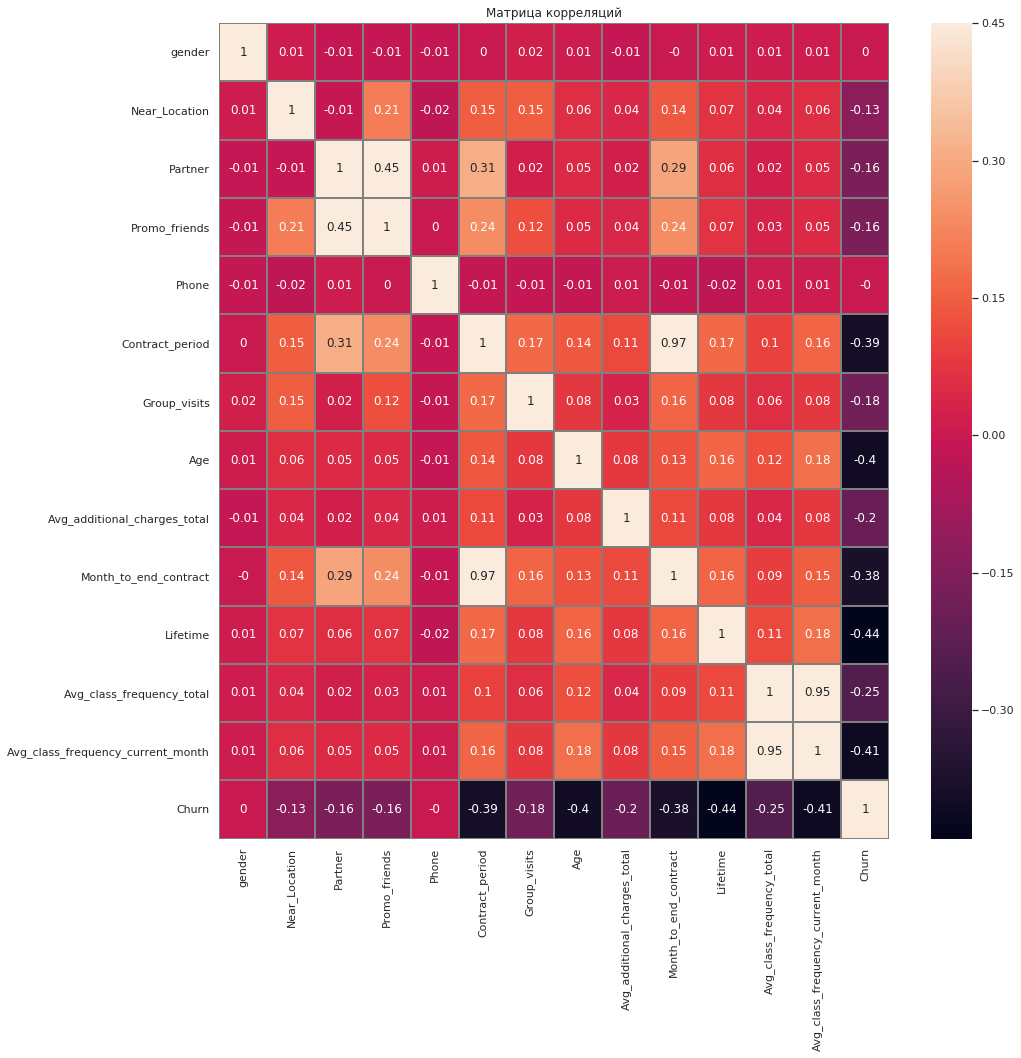

In [42]:
#нарисуем heatmap
sns.set(style='white')
plt.figure(figsize=(15, 15))
plt.title('Матрица корреляций')
ax = sns.heatmap(corr_m, annot=True, linewidths=1, linecolor='gray', vmax=0.45)

    Судя по матрице корреляций, нет признаков, с высокой вероятностью сообщающих правильный ответ.
    Зато есть две пары скоррелированных признаков "Contract_period" и "Month_to_end_contract",
    а так же "Avg_class_frequency_total" и "Avg_class_frequency_current_month"

## Шаг 3. Постройте модель прогнозирования оттока клиентов

In [43]:
# определим функцию, которая будет выводить наши метрики
def print_all_metrics(y_true, y_pred, y_proba, title = 'Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

In [44]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = df.drop(columns = ['Churn'])
y = df['Churn']

In [45]:
# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [46]:
# обучите StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [47]:
# Преобразуйте обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [48]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(random_state=0)
# обучим модель
lr_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]
# выведем все метрики
print_all_metrics(y_test, lr_predictions, lr_probabilities , title='Метрики для модели логистической регрессии:')

Метрики для модели логистической регрессии:
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.83
	F1: 0.84
	ROC_AUC: 0.97


In [49]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state=0) # Ваш код здесь
# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st) # Ваш код здесь
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1] # Ваш код здесь
# выведем все метрики
print_all_metrics(y_test, rf_predictions, rf_probabilities, title = 'Метрики для модели случайного леса:')

Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.81
	F1: 0.83
	ROC_AUC: 0.97


In [50]:
# сделаем все то же самое для алгоритма градиентного бустинга
gb_model = GradientBoostingClassifier(n_estimators = 100, random_state=0)
gb_model.fit(X_train_st, y_train)
gb_predictions = gb_model.predict(X_test_st)
gb_probabilities = gb_model.predict_proba(X_test_st)[:,1]
# выведем все метрики
print_all_metrics(y_test, gb_predictions, gb_probabilities, title = 'Метрики для модели градиентного бустинга:')

Метрики для модели градиентного бустинга:
	Accuracy: 0.93
	Precision: 0.88
	Recall: 0.84
	F1: 0.86
	ROC_AUC: 0.98


    Были построены модели бинарной классификации пользователей, где целевой признак — факт оттока пользователя в
    следующем месяце: LogisticRegression(), RandomForestClassifier(), GradientBoostingClassifier() 

        На основании метрик лучше всех себя показала модель GradientBoostingClassifier() по всем показателям:
        * Accuracy: 0.93
        * Precision: 0.88
        * Recall: 0.84
        * F1: 0.86
        * ROC_AUC: 0.98

## Шаг 4. Сделайте кластеризацию клиентов

### Матрица расстояний функцией linkage() на стандартизованной матрице признаков и отрисовка дендрограммы.


Договоримся за число кластеров принять n=5

In [51]:
X = df.drop('Churn', axis = 1)

In [52]:
# стандартизация данных перед работой с алгоритмами
sc = StandardScaler()
X_sc = sc.fit_transform(X)

km = KMeans(n_clusters = 5, random_state=0) # задаём число кластеров, равное 5
labels = km.fit_predict(X_sc) # применяем алгоритм к данным и формируем вектор кластеров

In [53]:
# Нарисуем дендограмму
from scipy.cluster.hierarchy import dendrogram, linkage

In [54]:
linked = linkage(X_sc, method = 'ward')

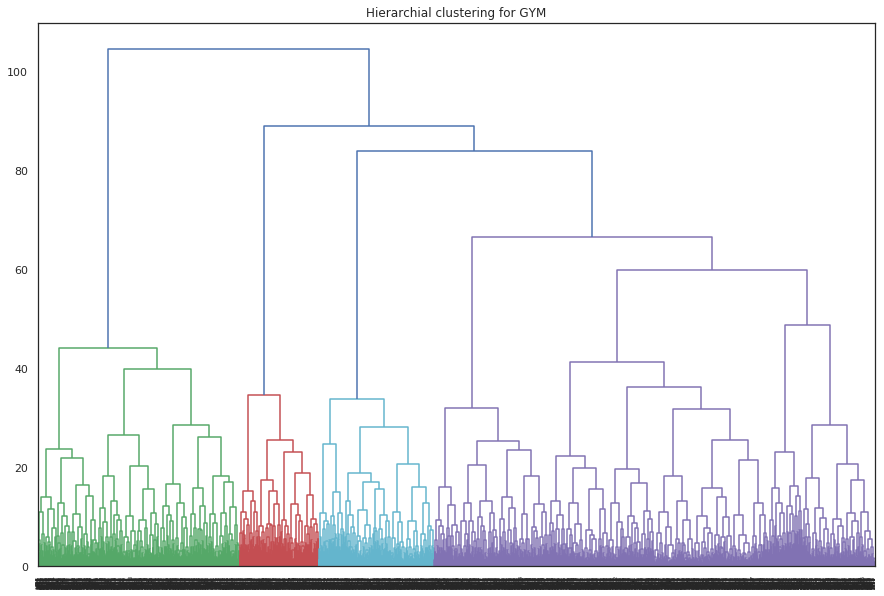

In [55]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show()

**Судя по диаграмме - всего 4 кластера**

In [56]:
# сохраним метки кластера в поле нашего датасета
df['cluster_gym'] = labels

# посчитаем метрику силуэта для нашей кластеризации
print('Silhouette_score: {:.2f}'.format(silhouette_score(X_sc, labels)))

Silhouette_score: 0.14


    Значение метрики оказалось не очень высоким.
    Объекты наблюдения не имеют явную структуру и ярко выроженного разделения.

### Cредние значения признаков для кластеров

In [57]:
# выводим статистику по средним значениям наших признаков по кластеру
df.groupby('cluster_gym').agg('mean').round(2)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
cluster_gym,,,,,,,,,,,,,,
0,0.50,0.96,0.78,0.57,1.0,10.88,0.54,29.98,160.71,9.95,4.74,1.98,1.98,0.03
1,0.52,0.86,0.47,0.31,0.0,4.79,0.43,29.30,143.96,4.48,3.92,1.85,1.72,0.27
2,0.50,0.00,0.46,0.08,1.0,2.35,0.22,28.48,135.46,2.20,2.81,1.66,1.48,0.44
3,0.49,1.00,0.35,0.24,1.0,1.95,0.34,28.17,131.62,1.86,2.44,1.25,1.01,0.51
4,0.56,0.98,0.36,0.23,1.0,2.67,0.47,30.13,161.72,2.46,4.90,2.85,2.85,0.07



Самый проблемный кластер №3, у которго среднее значение "Churn" - 0.51. Далее идет кластер №2 со среднем значением "Churn" 0.44.

Посмотрим, что характерно для двух проблемных кластерв:

- `gender` - не имеет значения, так как в 3ьем и во 2ом кластерах мужчин и женщин поравну - 0,49 и 0,5 соответственно
- `Near_Location` - в третьем кластере все клиенты живут или работают в одном районе с клубом, во втором кластере все клиенты живут или работают в другом районе.
- `Partner` - в третьем класстере в среднем 35% являются сотрудниками компании-партнёра клуба, во втором кластере 46%. Данные показатели близки к 4 кластеру (36%) и 1 кластеру (47%), но там отток клиентов не значительный
- `Promo_friends` - в третьем класстере 24% клиентов воспользовались акцией "приведи друга", похожий показатель в 4 кластере (23%), но там отток клиентов не значительный. Во втором кластере самый низкий показатель - 8%
- `Phone` - во всех кластерах указан телефон, кроме 1го кластера, там отток клиентов 27%
- `Contract_period` - в этих двух класстерах самая короткая длительность абонемента, в среднем 1.95 (3ий кластер) и 2.35 (второй кластер)
- `Group_visits` - в этих двух класстерах самый низкий показатель посещения групповых занятий, в среднем 0.34 (3ий кластер) и 0.22 (второй кластер)
- `Age` - В среднем в этих двух кластерах клиенты моложе, чем в других кластерах: средний возраст 28.17 (3ий кластер) и 28.48 (2ой кластер)
- `Avg_additional_charges_total` - в среднем в этих двух кластерах клиенты меньше всего тратили на доп.услуги: 131.62 (3ий кластер) и 135.46 (2ой кластер)
- `Month_to_end_contract` - в двух кластерах быстрее всех заканчивается срок действия абонемента: 1.86 (3ий кластер) и 2.20 (2ой кластер)
- `Lifetime` - В двух кластерах меньше всего прошло время с момента первого обращения в фитнес-центр (в месяцах): 2.44 (3ий кластер) и 2.81 (2ой кластер)
- `Avg_class_frequency_total` - в двух класстерах самая низкая средняя частота посещений в неделю за все время с начала действия абонемента: 1.25 (3ий кластер) и 1.66 (2ой кластер)
- `Avg_class_frequency_current_month` - в двух класстерах самая низкая средняя частота посещений в неделю за предыдущий месяц: 1.01 (3ий кластер) и 1.48 (2ой кластер)

### Распределения признаков для кластеров

Text(0, 0.5, 'Количество')

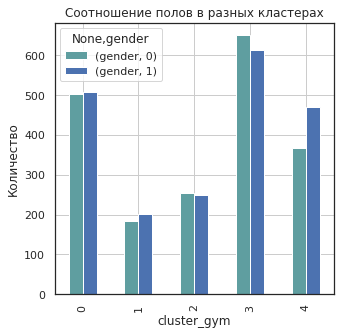

In [58]:
df.pivot_table(index='cluster_gym', columns='gender', aggfunc=({'gender':'count'}))\
    .plot(kind='bar', grid=True, color = ('cadetblue', 'b'), figsize=(5, 5))
plt.title('Соотношение полов в разных кластерах')
plt.ylabel('Количество')

    Видим, что во втором и третьем кластере примерно одинаковое количество женщин и мужчин.
    Пол не влияет на прогнозирование оттока клиентов

Text(0, 0.5, 'Количество')

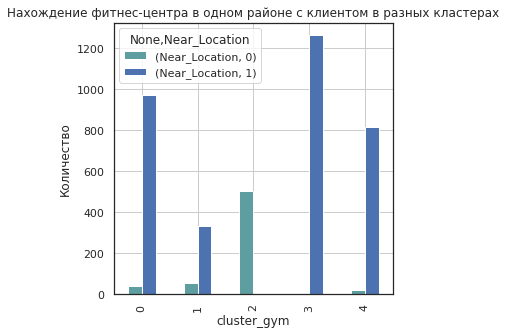

In [59]:
df.pivot_table(index='cluster_gym', columns='Near_Location', aggfunc=({'Near_Location':'count'}))\
    .plot(kind='bar', grid=True, color = ('cadetblue', 'b'), figsize=(5, 5))
plt.title('Нахождение фитнес-центра в одном районе с клиентом в разных кластерах')
plt.ylabel('Количество')

    В 0, 1, 4 кластерах большинство клиентов живут/работают в одном районе с клубом.
    Во 2 кластере все клиенты живут в другом райне.
    В 3ьем кластере все клиенты живут в этом же районе.  

Text(0, 0.5, 'Количество')

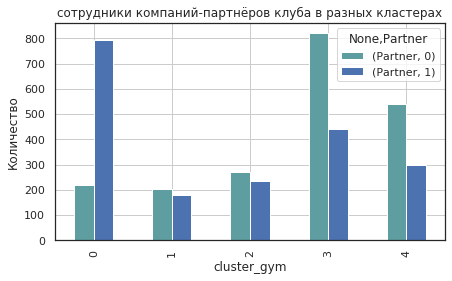

In [60]:
df.pivot_table(index='cluster_gym', columns='Partner', aggfunc=({'Partner':'count'}))\
    .plot(kind='bar', grid=True, color = ('cadetblue', 'b'), figsize=(7, 4))
plt.title('сотрудники компаний-партнёров клуба в разных кластерах')
plt.ylabel('Количество')

    В 3ьем кластере с самым большим оттоком клиентов самое большое число клиентов,
    не являющихся сотрудниками компаний-партнеров

Text(0, 0.5, 'Количество')

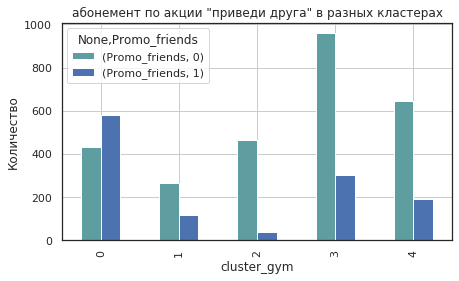

In [61]:
df.pivot_table(index='cluster_gym', columns='Promo_friends', aggfunc=({'Promo_friends':'count'}))\
    .plot(kind='bar', grid=True, color = ('cadetblue', 'b'), figsize=(7, 4))
plt.title('абонемент по акции "приведи друга" в разных кластерах')
plt.ylabel('Количество')

    Во третьем кластере самый высокий показаетль по количеству клиентов, которые не пользовались акцией "приведи друга"

Text(0, 0.5, 'Количество')

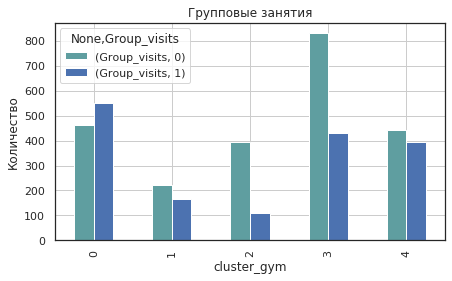

In [62]:
df.pivot_table(index='cluster_gym', columns='Group_visits', aggfunc=({'Group_visits':'count'}))\
    .plot(kind='bar', grid=True, color = ('cadetblue', 'b'), figsize=(7, 4))
plt.title('Групповые занятия')
plt.ylabel('Количество')

    В третьем кластере самый высокий показаетль по количеству клиентов, не посещавщих групповые занятия.
    Далее идет второй кластер

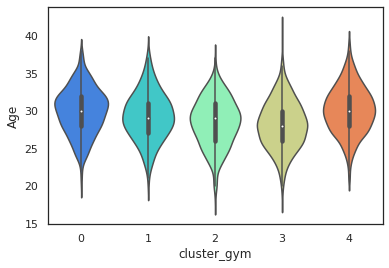

In [63]:
sns.violinplot(x="cluster_gym", y="Age", data=df, palette='rainbow')

    Во втором и третьем кластере присутствуют клиенты младше 20 лет.
    В третьем класстере медиана в районе 27 лет, в остальных кластерах выше

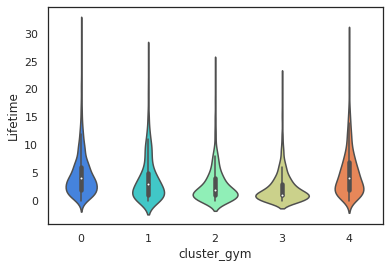

In [64]:
sns.violinplot(x="cluster_gym", y="Lifetime", data=df, palette='rainbow')

    Во втором и третьем кластере большинство значений приходится на 1-2 месяца

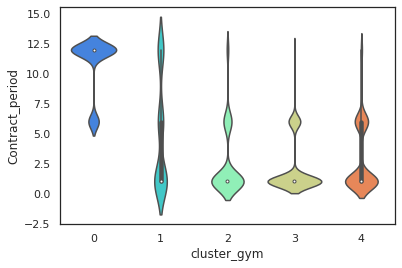

In [65]:
sns.violinplot(x="cluster_gym", y="Contract_period", data=df, palette='rainbow');

    Во втором и третьем кластере большая часть значений выпадает на абонемент длиною 1 месяц,
    небольшое количество - на абонементы длиною в 6 месяцев. 

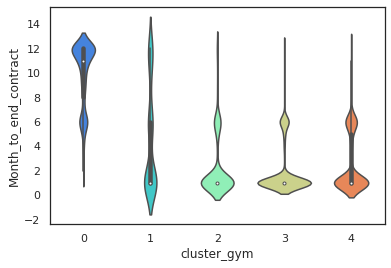

In [66]:
sns.violinplot(x="cluster_gym", y="Month_to_end_contract", data=df, palette='rainbow')

    В третьем кластере большинство значений приходится на 1 месяц.

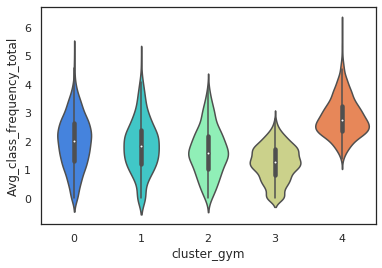

In [67]:
sns.violinplot(x="cluster_gym", y="Avg_class_frequency_total", data=df, palette='rainbow')

    В третьем кластере самая низкая средняя частота посещений в неделю за предыдущий месяц

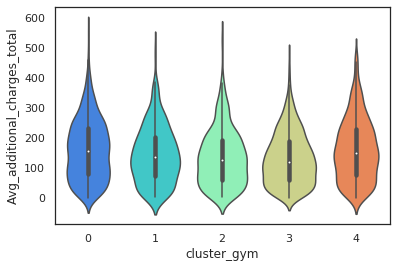

In [68]:
sns.violinplot(x="cluster_gym", y="Avg_additional_charges_total", data=df, palette='rainbow')

    По графику сильных различий между кластерами нет в средней частоте посещений в неделю за все время
    с начала действия абонемента

### Доля оттока для каждого полученного кластера 

In [69]:
proportion_churn = df.groupby(['cluster_gym', 'Churn']).agg({'Churn':'count'})
proportion_churn

Churn
cluster_gym Churn       
0           0        983
            1         28
1           0        282
            1        103
2           0        281
            1        224
3           0        613
            1        649
4           0        780
            1         57

Text(0, 0.5, 'Количество')

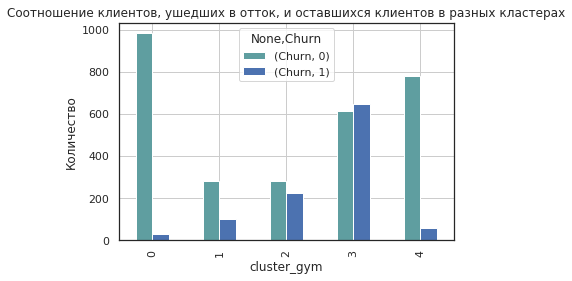

In [70]:
df.pivot_table(index='cluster_gym', columns='Churn', aggfunc=({'Churn':'count'}))\
    .plot(kind='bar', grid=True, color = ('cadetblue', 'b'), figsize=(6, 4))
plt.title('Соотношение клиентов, ушедших в отток, и оставшихся клиентов в разных кластерах')
plt.ylabel('Количество')

**Видим, что лучше всех показатели у нулевого кластера:**

    
    97,23% клиента продолжили посещение и 2,77% клиента ушли в отток
    
**На втором месте четвертый кластер:**

    
    93,19% клиента продолжили посещение и 6,8% клиента ушли в отток


**На третьем месте первый кластер:**

    
    73,25% клиента продолжили посещение и 26,75% клиента ушли в отток


**На четвертом месте второй кластер:**

    
    55.64% клиента продолжили посещение и 44,36% клиента ушли в отток


**На пятом месте третий кластер:**

    
    48.57% клиента продолжили посещение и 51,43 % клиента ушли в отток

## Шаг 5. Сформулируйте выводы и сделайте базовые рекомендации по работе с клиентами

- Проведенный анализ показал, что чаще остаются клиенты, у которых срок действия абонемента 6-12 месяцев. У таких клиентов длинее Lifetime. Рекомендации: фитнесс-центр должен стимулировать покупателей на покупку долгосрочных абонементов.


- Это можно сделать при помощи скидок на первый абонемент ("приведи друга", "сотрудник компании-партнера"). Данные показатели имели вес в разделении на кластеры.


- Фитнес-центру необходимо обратить внимание, что клиенты в молодой возрастной группе чаще уходят в отток. Необходимо продумать маркетинговых действий на удержание клиентов до 25 лет.


- Клиенты со средней частотой посещения 1 раз в неделю уходят чаще, чем клиенты со средней частотой посещения 2-3 раза


- Кластеры, в которых клиенты больше посещали групповые занятия, имеют лучше показатели по оттоку


- У клиентов, прекративших посещения, часта заканчивался абонемент. Стоит обратить пристальное внимание на клиентов, у которых срок абонемента подходит к концу. Уточнить все ли им нравиться, чтобы они хотели изменить/улучшить, предложить акцию, специальные условия. Убедиться, что клиент продлит абонемент.


- Признак 'Near_Location' оказался противоречивым. На первый взгляд логично, что клиентам удобно посещать клубы в одном районе с домом или работой. И у клиентов, проживающих в другом районе, больше вероятности уйти в отток из-за неудобного месторасположения. Но например, в третьем кластере отсутствуют клиенты, которые проживают или работают в другом районе. А у этого кластера самый большой показатель по оттоку. Значит в этом класстере получилась сумма факторов превалирующая над признаком 'Near_Location'